### Load the dataset

In [ ]:

import warnings
warnings.filterwarnings("ignore")

import pandas as pd 
data = pd.read_pickle("/content/drive/MyDrive/TICNN_Implementation/TICNN/final_text_df.pkl")

### Imp libraries

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import style
style.use('seaborn')
import seaborn as sns
from tensorflow import keras as k
from sklearn.model_selection import train_test_split
from gensim.models import KeyedVectors
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

### GloVe Embeddings

In [ ]:
from pathlib import Path
import numpy as np
from keras.preprocessing.text import Tokenizer

def load_glove(url):
    f = open(url.absolute())
    embeddings_index = dict()
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = coefs
    f.close()
    return embeddings_index

GLOVE_URL = Path("/content/drive/MyDrive/TICNN_Implementation/TICNN/glove.6B.100d.txt")
glove = load_glove(GLOVE_URL)
t = Tokenizer()
t.fit_on_texts(glove.keys())
vocab_size = (len(t.word_index)+1)
#+1 for out of vocabulary words.

### Padding the text to make it of length 400

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

df=pd.DataFrame()
df["text"] = (pad_sequences(data["text"], maxlen=400,padding="post", truncating="post")).tolist()
df["title"] = pad_sequences(data["title"], maxlen=400,padding="post", truncating="post").tolist()

### Embedding Matrix

In [ ]:
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in t.word_index.items():
    embedding_vector = glove.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

### Train-Test-Val Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df[['text', 'title']], data['type'], test_size=0.1, random_state=1)

#Train - valid
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.1, random_state=1)

### Text inputs

In [ ]:
X_train_title = X_train['title']
X_train_content = X_train['text']

X_valid_title = X_valid['title']
X_valid_content = X_valid['text']

X_test_title = X_test['title']
X_test_content = X_test['text']

In [ ]:

train_fit = [np.asarray(X_train_title.tolist()), 
             np.asarray(X_train_content.tolist())]

valid_fit = [np.asarray(X_valid_title.tolist()), 
             np.asarray(X_valid_content.tolist())]

test_fit = [np.asarray(X_test_title.tolist()), 
             np.asarray(X_test_content.tolist())]

### Model

In [ ]:
from numpy.random import seed

import keras.backend as K
import tensorflow as tf

### Metrics

In [ ]:
def precision(y_true,y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  prcsn = true_positives / (predicted_positives + K.epsilon())
  return prcsn

def recall(y_true,y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  rcll = true_positives / (possible_positives + K.epsilon())
  return rcll


def f1(y_true, y_pred): #taken from old keras source code
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  precision = true_positives / (predicted_positives + K.epsilon())
  recall = true_positives / (possible_positives + K.epsilon())
  f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
  return f1_val

### Architecture

In [ ]:
title_input = k.layers.Input(shape=(400), name='title_input')
inp = k.layers.Embedding(input_dim=vocab_size,output_dim=100, weights=[embedding_matrix], trainable=False,)(title_input)
x = k.layers.Bidirectional(k.layers.GRU(96))(inp)

#input_content
content_input = k.layers.Input(shape=(400), name='content_input')
inp2 = k.layers.Embedding(output_dim=100, input_dim=vocab_size, weights=[embedding_matrix], trainable=False)(content_input)
x2 = k.layers.Bidirectional(k.layers.GRU(251))(inp2)

#Merge
x = k.layers.concatenate([x, x2])

#Common part
x = k.layers.Dense(51, activation='relu')(x)
x = k.layers.Dropout(0.222)(x)
x = k.layers.Dense(25, activation='relu')(x)
x = k.layers.Dropout(0.2)(x)

out = k.layers.Dense(1, activation='sigmoid')(x)

#Build model
model = k.models.Model(inputs=[title_input, content_input], outputs=[out])

model.compile(optimizer =tf.keras.optimizers.Adam(learning_rate=0.00001,decay=0.0001),metrics=[precision,recall, f1],loss= "binary_crossentropy")

### Load weights

In [ ]:
model.load_weights("/content/drive/MyDrive/TICNN_Implementation/GRU-400/model20k_400.h5")

### predicting on test set

In [ ]:
pred=model.predict(test_fit,verbose=1)

63/63 [==============================] - 42s 668ms/step


### taking 0.5 as threshold
since sigmoid activation is used with one neuron, it give the probabilty of class 1. So if the probability of class 1(REAL) is low, then it implies that it belongs to class 0(FAKE)

In [ ]:
p=[]
for i in pred:
  if(i>0.5):
    p.append(1)
  else:
    p.append(0)

# **Results**

In [ ]:
results={}

In [ ]:
from sklearn.metrics import f1_score
results["f1_score"]=[f1_score(np.array(y_test.tolist()),p)]

from sklearn.metrics import precision_score
results["precision"]=[precision_score(np.array(y_test.tolist()),p)]

from sklearn.metrics import recall_score
results["recall"]=[recall_score(np.array(y_test.tolist()),p)]

from sklearn.metrics import accuracy_score
results["accuracy"]=[accuracy_score(np.array(y_test.tolist()),p)]

In [ ]:
pd.DataFrame.from_dict(results)

,f1_score,precision,recall,accuracy
0,0.885702,0.893617,0.877926,0.864635


### Confusion Matrix

[[1050  146]
 [ 125  681]]


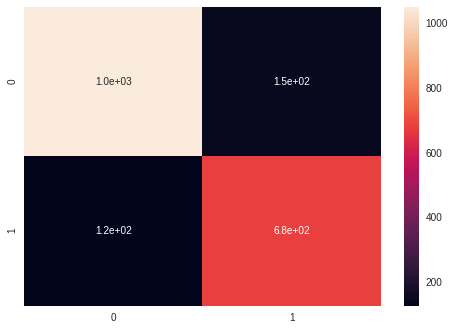

In [ ]:
from sklearn.metrics import confusion_matrix

labels = [1,0]
# 1===> REAL NEWS
# 0===> FAKE NEWS
cm = confusion_matrix(np.array(y_test.tolist()),p, labels)
print(cm)
import seaborn as sns
sns.heatmap(cm, annot=True)